# Capstone Project - The Battle of the Neighborhoods (Week 2)

**Note**: To view all contents within this notebook (i.e. including the Folium maps), please click [here.](https://nbviewer.jupyter.org/github/tanyadyne/Coursera_Capstone/blob/master/The%20Battle%20of%20the%20Neighborhoods/The%20Battle%20of%20the%20Neighborhoods%20-%20Week%202%20-%20Notebook.ipynb)

### Table of Contents:

* [Introduction](#intro)
* [Data](#data)
    * [Part 1: Preprocessing](#stage1)
    * [Part 2: Scraping](#stage2)
* [Methodology](#methodology)
    * [Part 3: Exploratory Data Analysis](#stage3)
    * [Part 4: Modelling](#stage4)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

### Introduction and Overview <a class="anchor" id="intro"></a>

To recap:

 - The aim of the project is to i) **identify** the safest borough in London based on the crime rate, ii) **explore** the neighborhoods of that borough to determine the 10 most common venues in each neighborhood, and iii) **cluster** the neighborhoods using k-means clustering.
 - The target audience are those looking to relocate to London and wish to factor in safety in their search for a new home. This is therefore especially relevant to those that have vulnerable family members, such as the eldery, or young children.
 - Three sources of data will be used in this project: i) a dataset containing the number of crimes in each borough in London, ii) a wikipedia page containing a list of the London boroughs and their characteristics, and finally iii) a list of the neighborhoods in the borough of Richmond upon Thames.
 
**The project will therefore progress as follows**:

Data

 - Part 1: Preprocessing of the dataset containing the crime statistics of each borough 
 - Part 2: Scraping of additional information about each borough from a wikipedia page
 
Methodology

 - Part 3: Exploratory Data Analysis (identifying and visualising the safest borough)
 - Part 4: Modelling (nearest venues/one-hot encoding/k-means clustering)
 
Analysis:

 - Analysing and characterising the clusters
 
Finally, the results will be discussed, followed by a conclusion about the successes of the project and any further improvements that could potentially be made.

### Data <a class="anchor" id="data"></a>

#### Part 1: Preprocessing of the dataset containing the crime statistics <a class="anchor" id="stage1"></a>

In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

# !conda install -c conda-forge geocoder --yes
import geocoder
# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

# !conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium imported!')
print('Libraries imported!')

Folium imported!
Libraries imported!


In [2]:
# read in the data
df = pd.read_csv('london_crime.csv')
df.head()

,MajorText,MinorText,LookUp_BoroughName,201805,201806,201807,201808,201809,201810,201811,...,201907,201908,201909,201910,201911,201912,202001,202002,202003,202004
0,Arson and Criminal Damage,Arson,Barking and Dagenham,4,12,6,5,3,8,5,...,5,3,6,9,8,6,4,5,6,2
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,126,123,127,101,107,132,105,...,134,118,109,109,97,121,97,103,108,82
2,Burglary,Burglary - Business and Community,Barking and Dagenham,24,33,30,18,33,32,39,...,31,35,37,30,30,25,31,17,27,29
3,Burglary,Burglary - Residential,Barking and Dagenham,93,77,94,84,99,94,106,...,71,67,80,97,114,130,116,123,97,56
4,Drug Offences,Drug Trafficking,Barking and Dagenham,8,6,8,7,10,7,7,...,11,7,7,10,12,3,11,3,6,9


In [3]:
# taking the most recent year (2019-04 to 2020-04) and dropping the rest
df.drop(list(df.filter(regex = '2018')), axis = 1, inplace = True)
df1 = df.drop(['201901', '201902', '201903'], axis = 1)
df1.head()

,MajorText,MinorText,LookUp_BoroughName,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003,202004
0,Arson and Criminal Damage,Arson,Barking and Dagenham,5,11,3,5,3,6,9,8,6,4,5,6,2
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,130,139,113,134,118,109,109,97,121,97,103,108,82
2,Burglary,Burglary - Business and Community,Barking and Dagenham,27,22,27,31,35,37,30,30,25,31,17,27,29
3,Burglary,Burglary - Residential,Barking and Dagenham,96,114,96,71,67,80,97,114,130,116,123,97,56
4,Drug Offences,Drug Trafficking,Barking and Dagenham,5,9,6,11,7,7,10,12,3,11,3,6,9


In [4]:
# checking dataframe dimensions
df1.shape

(1567, 16)

In [5]:
# get total crimes from 2019-04 to 2020-04
df1['Total Crimes'] = df1.sum(axis=1)
df1.head()

,MajorText,MinorText,LookUp_BoroughName,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003,202004,Total Crimes
0,Arson and Criminal Damage,Arson,Barking and Dagenham,5,11,3,5,3,6,9,8,6,4,5,6,2,73
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,130,139,113,134,118,109,109,97,121,97,103,108,82,1460
2,Burglary,Burglary - Business and Community,Barking and Dagenham,27,22,27,31,35,37,30,30,25,31,17,27,29,368
3,Burglary,Burglary - Residential,Barking and Dagenham,96,114,96,71,67,80,97,114,130,116,123,97,56,1257
4,Drug Offences,Drug Trafficking,Barking and Dagenham,5,9,6,11,7,7,10,12,3,11,3,6,9,99


In [6]:
# only keep the total crimes and drop the individual month columns
df_crimes = df1.drop(df.loc[:, '201904':'202004'].columns, axis=1)
df_crimes.head()

,MajorText,MinorText,LookUp_BoroughName,Total Crimes
0,Arson and Criminal Damage,Arson,Barking and Dagenham,73
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,1460
2,Burglary,Burglary - Business and Community,Barking and Dagenham,368
3,Burglary,Burglary - Residential,Barking and Dagenham,1257
4,Drug Offences,Drug Trafficking,Barking and Dagenham,99


In [7]:
# rename the columns
df_crimes.rename(columns={'MajorText':'Major Category', 'MinorText':'Minor Category', 'LookUp_BoroughName':'Borough'}, inplace=True)
df_crimes.head()

,Major Category,Minor Category,Borough,Total Crimes
0,Arson and Criminal Damage,Arson,Barking and Dagenham,73
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,1460
2,Burglary,Burglary - Business and Community,Barking and Dagenham,368
3,Burglary,Burglary - Residential,Barking and Dagenham,1257
4,Drug Offences,Drug Trafficking,Barking and Dagenham,99


In [8]:
# retreiving total crimes per borough
total_crimes = df_crimes.groupby('Borough').sum().sort_values('Total Crimes')
# note that we'll drop this borough as it is not technically considered a London borough
total_crimes.drop(['London Heathrow and London City Airports'],axis=0,inplace=True)
total_crimes.reset_index(inplace=True)
total_crimes.head(11)

,Borough,Total Crimes
0,Richmond upon Thames,13608
1,Kingston upon Thames,13727
2,Sutton,15149
3,Merton,15376
4,Harrow,18485
5,Bexley,18973
6,Havering,20114
7,Barking and Dagenham,21617
8,Hammersmith and Fulham,24724
9,Kensington and Chelsea,25740


#### Part 2: Scraping additional information of the different boroughs from Wikipedia <a class="anchor" id="stage2"></a>

In [9]:
# retrieving the data from the wikipedia page
url = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
wiki_page = requests.get(url).text

# parse the doc using lxml's HTML parser
soup = BeautifulSoup(wiki_page, 'lxml')
# print(soup.prettify())  # unedit to view full html doc

In [10]:
# locate the table of interest
table = soup.find('table', {'class':'wikitable sortable'})
# table   # unedit to view table contents

In [11]:
# extract the data within <tr>
data = table.findAll('tr')
# data  # unedit to view full output

In [12]:
# store the data row by row in an empty new list
table = []

# loop through each row in the table and append it to the new empty list
for row in data:
    table.append([t.text.strip() for t in row.findAll('td')])
    
# create a new dataframe for the table
london_table = pd.DataFrame(table, columns = ['Borough','Inner','Status','Local authority','Political control','Headquarters',
                                              'Area (sq mi)','Population (2013 est)','Coordinates','Nr. in map'])
london_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est),Coordinates,Nr. in map
0,None,None,None,None,None,None,None,None,None,None
1,Barking and Dagenham [note 1],,,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,"194,352",51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...,25
2,Barnet,,,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,"369,088",51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...,31
3,Bexley,,,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,"236,687",51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...,23
4,Brent,,,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,"317,264",51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...,12


In [13]:
# clean up the layout of the df
london_table.drop(london_table.head(1).index, inplace=True)
london_table.reset_index(drop=True, inplace=True)
london_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est),Coordinates,Nr. in map
0,Barking and Dagenham [note 1],,,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,"194,352",51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...,25
1,Barnet,,,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,"369,088",51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...,31
2,Bexley,,,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,"236,687",51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...,23
3,Brent,,,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,"317,264",51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...,12
4,Bromley,,,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,"317,899",51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...,20


In [14]:
# as can be seen, the coordinates are not correct, therefore we will drop the column for now
london_table.drop(['Coordinates'], axis=1, inplace=True)
london_table.head(10)

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est),Nr. in map
0,Barking and Dagenham [note 1],,,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,"194,352",25
1,Barnet,,,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,"369,088",31
2,Bexley,,,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,"236,687",23
3,Brent,,,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,"317,264",12
4,Bromley,,,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,"317,899",20
5,Camden,Y,,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,"229,719",11
6,Croydon,,,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,"372,752",19
7,Ealing,,,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,"342,494",13
8,Enfield,,,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,"320,524",30
9,Greenwich [note 2],Y [note 3],Royal,Greenwich London Borough Council,Labour,"Woolwich Town Hall, Wellington Street",18.28,"264,008",22


In [15]:
# clean up the naming of the Borough column
london_table.replace(to_replace='note 1',value='',regex=True,inplace=True)
london_table.replace(to_replace='note 2',value='',regex=True,inplace=True)
london_table.replace(to_replace='note 3',value='',regex=True,inplace=True)
london_table.replace(to_replace='note 4',value='',regex=True,inplace=True)
london_table.replace(to_replace='note 5',value='',regex=True,inplace=True)
london_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est),Nr. in map
0,Barking and Dagenham [],,,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,"194,352",25
1,Barnet,,,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,"369,088",31
2,Bexley,,,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,"236,687",23
3,Brent,,,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,"317,264",12
4,Bromley,,,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,"317,899",20


In [16]:
# check if the borough names match in both dataframes
set(total_crimes.Borough) - set(london_table.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

These three boroughs don't match because the entries in london_table contain the unneccesary '[]' brackets. We will resolve this.

In [17]:
# change the borough names to match
london_table.iloc[0,0] = 'Barking and Dagenham'
london_table.iloc[9,0] = 'Greenwich'
london_table.iloc[11,0] = 'Hammersmith and Fulham'

In [18]:
# once again check if the borough names match
set(total_crimes.Borough) - set(london_table.Borough)

set()

The borough names in both dataframes now match. We can therefore go ahead and combine the two dataframes.

In [19]:
# merge the two dataframes
ldn_crime = pd.merge(london_table, total_crimes, on='Borough')
ldn_crime.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est),Nr. in map,Total Crimes
0,Barking and Dagenham,,,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,"194,352",25,21617
1,Barnet,,,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,"369,088",31,32925
2,Bexley,,,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,"236,687",23,18973
3,Brent,,,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,"317,264",12,32039
4,Bromley,,,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,"317,899",20,26507


Because we are not necessarily interested in all the columns, we will drop a few to clean up the dataframe.

In [20]:
# drop unwanted columns
ldn_crime.drop(['Inner','Status','Local authority','Political control','Headquarters','Nr. in map'],axis=1,inplace=True)
ldn_crime.head(11)

,Borough,Area (sq mi),Population (2013 est),Total Crimes
0,Barking and Dagenham,13.93,"194,352",21617
1,Barnet,33.49,"369,088",32925
2,Bexley,23.38,"236,687",18973
3,Brent,16.70,"317,264",32039
4,Bromley,57.97,"317,899",26507
5,Camden,8.40,"229,719",41109
6,Croydon,33.41,"372,752",36965
7,Ealing,21.44,"342,494",33317
8,Enfield,31.74,"320,524",32348
9,Greenwich,18.28,"264,008",30513


Because we are interested in the **crime rate** rather than the total crimes in each borough, we will need to calculate a new column. The crime rate is calculated by first dividing the number of reported crimes by the population, then multiplying that by 1,000. This will get us the crime rate per 1,000 residents.

In [21]:
# before we calculate the crime rate, we'll need to convert the population column to an integer 
ldn_crime.replace(',','',regex=True,inplace=True)  # remove commas
ldn_crime['Population (2013 est)'] = ldn_crime['Population (2013 est)'].astype(int)

# calculating the crime rate
ldn_crime['Crime Rate'] = (ldn_crime['Total Crimes'] / ldn_crime['Population (2013 est)'])*1000
ldn_crime.head()

,Borough,Area (sq mi),Population (2013 est),Total Crimes,Crime Rate
0,Barking and Dagenham,13.93,194352,21617,111.226023
1,Barnet,33.49,369088,32925,89.206368
2,Bexley,23.38,236687,18973,80.160719
3,Brent,16.70,317264,32039,100.985299
4,Bromley,57.97,317899,26507,83.381829


In [22]:
# round the crime rate to two decimal places
ldn_crime['Crime Rate'] = ldn_crime['Crime Rate'].round(2)
ldn_crime.sort_values('Crime Rate').head(10)

,Borough,Area (sq mi),Population (2013 est),Total Crimes,Crime Rate
25,Richmond upon Thames,22.17,191365,13608,71.11
22,Merton,14.52,203223,15376,75.66
13,Harrow,19.49,243372,18485,75.95
27,Sutton,16.93,195914,15149,77.32
2,Bexley,23.38,236687,18973,80.16
19,Kingston upon Thames,14.38,166793,13727,82.30
14,Havering,43.35,242080,20114,83.09
4,Bromley,57.97,317899,26507,83.38
30,Wandsworth,13.23,310516,27611,88.92
1,Barnet,33.49,369088,32925,89.21


### Methodology <a class="anchor" id="methodology"></a>

#### Part 3: Exploratory Data Analysis <a class="anchor" id="stage3"></a>

In this section, we will:

 - visualise the crime rates in the London boroughs to identify the safest borough
 - extract the neighborhoods in that borough to find the 10 most common venues in each neighborhood.

First, let's produce some descriptive statistics of our data.

In [23]:
ldn_crime.describe()

,Population (2013 est),Total Crimes,Crime Rate
count,32.000000,32.000000,32.000000
mean,262777.718750,29913.906250,115.808750
std,57346.611409,12411.117231,52.630362
min,155594.000000,13608.000000,71.110000
25%,224047.500000,23947.250000,87.535000
50%,263697.000000,29668.500000,100.955000
75%,311447.500000,34280.500000,129.797500
max,372752.000000,82479.000000,363.600000


Let's visualise the 5 boroughs that have the highest crime rates and the 5 boroughs that have the lowest crime rates.

In [24]:
# use the inline backend to generate plots within the browser
%matplotlib inline

# download matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
# use ggplot-like style
mpl.style.use('ggplot')  

# associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__)

Matplotlib version:  3.1.3


Retreive and visualise the 5 boroughs with the **highest** crime rates

In [25]:
# sort the table in descending order to see the 5 boroughs with the highest crime rates
ldn_crime.sort_values(['Crime Rate'], ascending=False, axis=0, inplace=True)
df_top5 = ldn_crime.head(5)
df_top5

,Borough,Area (sq mi),Population (2013 est),Total Crimes,Crime Rate
31,Westminster,8.29,226841,82479,363.60
5,Camden,8.40,229719,41109,178.95
18,Kensington and Chelsea,4.68,155594,25740,165.43
17,Islington,5.74,215667,31747,147.20
10,Hackney,7.36,257379,35647,138.50


<Figure size 432x288 with 0 Axes>

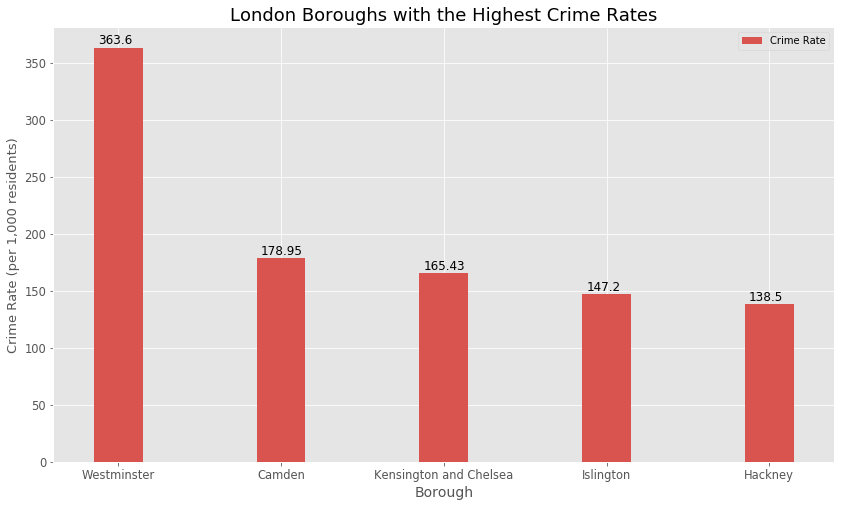

In [26]:
# visualise the results 

chart_top5 = df_top5[['Borough','Crime Rate']]
chart_top5.set_index('Borough', inplace=True)

fig = plt.figure()

ax = chart_top5.plot(kind='bar',
                     figsize=(14,8),
                     width=0.3,
                     color='#d9534f',
                     fontsize=11.5,
                     rot=0)

ax.set_ylabel('Crime Rate (per 1,000 residents)', fontsize=13)
ax.set_xlabel('Borough', fontsize=14)
ax.set_title('London Boroughs with the Highest Crime Rates', fontsize=18)

# displaying the crime rate above the bars

for p in ax.patches:
    width,height = p.get_width(), p.get_height()   
    x,y = p.get_xy()
    ax.annotate('{:}'.format(height), (x + 0.025, y + height + 3), fontsize=12)


Retreive and visualise the 5 boroughs with the **lowest** crime rates

In [27]:
# sort the table in ascending order to see the 5 boroughs with the lowest crime rates
ldn_crime.sort_values(['Crime Rate'], ascending=True, axis=0, inplace=True)
df_low5 = ldn_crime.head(5)
df_low5

,Borough,Area (sq mi),Population (2013 est),Total Crimes,Crime Rate
25,Richmond upon Thames,22.17,191365,13608,71.11
22,Merton,14.52,203223,15376,75.66
13,Harrow,19.49,243372,18485,75.95
27,Sutton,16.93,195914,15149,77.32
2,Bexley,23.38,236687,18973,80.16


<Figure size 432x288 with 0 Axes>

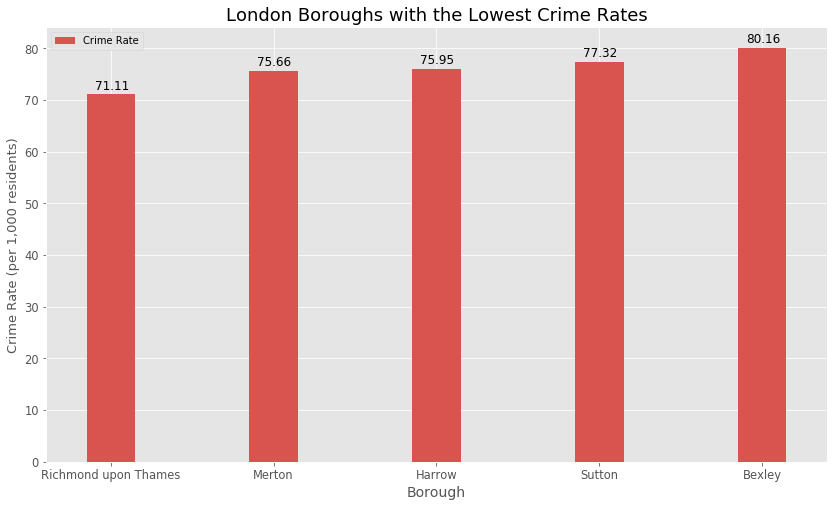

In [28]:
# visualise the results 

chart_low5 = df_low5[['Borough','Crime Rate']]
chart_low5.set_index('Borough', inplace=True)

fig = plt.figure()

ax1 = chart_low5.plot(kind='bar',
                     figsize=(14,8),
                     width=0.3,
                     color='#d9534f',
                     fontsize=11.5,
                     rot=0)

ax1.set_ylabel('Crime Rate (per 1,000 residents)', fontsize=13)
ax1.set_xlabel('Borough', fontsize=14)
ax1.set_title('London Boroughs with the Lowest Crime Rates', fontsize=18)

# displaying the crime rate above the bars

for p in ax1.patches:
    width,height = p.get_width(), p.get_height()   
    x,y = p.get_xy()
    ax1.annotate('{:}'.format(height), (x + 0.05, y + height + 1), fontsize=12)

As we have now determined, the borough with the lowest recorded crime rate for the period between April 2019 and April 2020 is 'Richmond upon Thames'. Let's look further into this borough.

In [29]:
df_RuT = df_low5[df_low5['Borough'] == 'Richmond upon Thames']
df_RuT

,Borough,Area (sq mi),Population (2013 est),Total Crimes,Crime Rate
25,Richmond upon Thames,22.17,191365,13608,71.11


Let's quickly compare that with the mean values of all the boroughs

In [30]:
ldn_mean = ldn_crime.describe().loc[['mean']]
ldn_mean.round(2)

,Population (2013 est),Total Crimes,Crime Rate
mean,262777.72,29913.91,115.81


Although the population of Richmond upon Thames is not far off from the mean population (roughly -71,412), it impressively has half the mean crime rate and half the mean number of total crimes. Another interesting takeaway is that the boroughs with the lowest crime rates had significantly larger areas (between 14 and 24 sq miles) whilst the boroughs with the highest crime rates had much smaller areas (between 4 and 8 sq miles). 

Let us now focus on the crimes that have occurred within the borough of Richmond upon Thames (from here referred to as RuT).

In [31]:
# retreive the crime data for RuT
df_RCrimes = df_crimes.loc[df_crimes['Borough'] == 'Richmond upon Thames']
df_RCrimes.head(40)

,Major Category,Minor Category,Borough,Total Crimes
1235,Arson and Criminal Damage,Arson,Richmond upon Thames,37
1236,Arson and Criminal Damage,Criminal Damage,Richmond upon Thames,1038
1237,Burglary,Burglary - Business and Community,Richmond upon Thames,326
1238,Burglary,Burglary - Residential,Richmond upon Thames,1234
1239,Drug Offences,Drug Trafficking,Richmond upon Thames,28
1240,Drug Offences,Possession of Drugs,Richmond upon Thames,399
1241,Miscellaneous Crimes Against Society,Dangerous Driving,Richmond upon Thames,1
1242,Miscellaneous Crimes Against Society,"Disclosure, Obstruction, False or Misleading S...",Richmond upon Thames,1
1243,Miscellaneous Crimes Against Society,Exploitation of Prostitution,Richmond upon Thames,0
1244,Miscellaneous Crimes Against Society,Forgery or Use of Drug Prescription,Richmond upon Thames,0


In [32]:
# group the crimes by the major category and sort
df_RC = df_RCrimes.groupby('Major Category')['Total Crimes'].sum().reset_index().sort_values(by='Total Crimes')
df_RC

,Major Category,Total Crimes
4,Possession of Weapons,57
3,Miscellaneous Crimes Against Society,126
7,Sexual Offences,302
6,Robbery,405
2,Drug Offences,427
5,Public Order Offences,904
0,Arson and Criminal Damage,1075
1,Burglary,1560
9,Vehicle Offences,2514
8,Theft,3041


In [33]:
# to make plotting easier, transpose the rows as columns
df_trans = df_RC.T
df_trans.columns = df_trans.iloc[0]
df_trans = df_trans[1:]
df_trans.reset_index(level=0, inplace=True)  # turning index into column
df_trans

Major Category,index,Possession of Weapons,Miscellaneous Crimes Against Society,Sexual Offences,Robbery,Drug Offences,Public Order Offences,Arson and Criminal Damage,Burglary,Vehicle Offences,Theft,Violence Against the Person
0,Total Crimes,57,126,302,405,427,904,1075,1560,2514,3041,3197


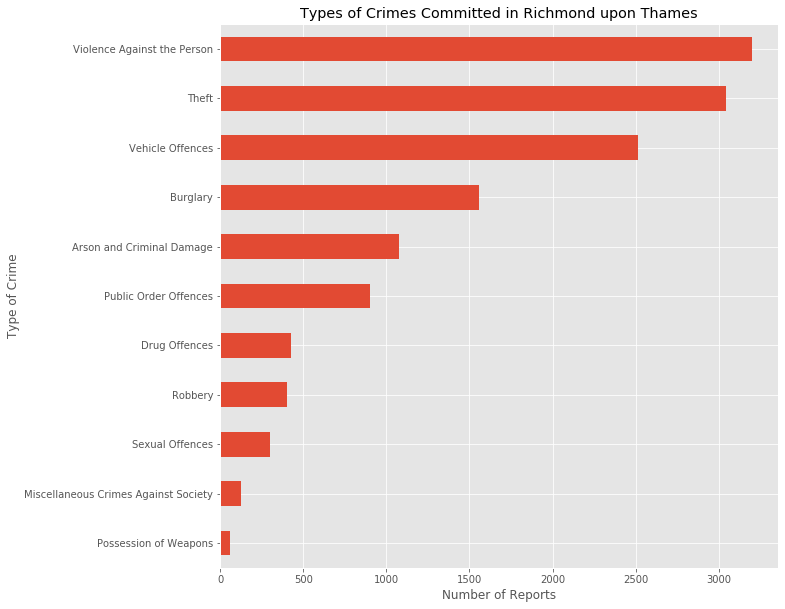

In [34]:
# visualise the results
df_RC.set_index('Major Category')['Total Crimes'].plot(kind='barh',grid=True,figsize=(10,10))
plt.xlabel('Number of Reports')
plt.ylabel('Type of Crime')
plt.title('Types of Crimes Committed in Richmond upon Thames')
plt.show()

As we can see, the two most common types of crime committed in Richmond upon Thames are violence against another person and theft, whilst the least common types of crime are possession of weapons, sexual offences, and miscellaneous crimes. Whilst RuT is the safest borough, and crimes are not all that common, knowing the most common types of crimes that are committed will help individuals better prepare for such cases. For example, because violence and theft are the most common types of crime, one might keep safe by reducing interaction with people they don't know, as well as being vigilant of their personal belongings when in public.

Now that we have a good understanding of the overall picture, let's delve deeper and look into the different neighborhoods  that are in Richmond upon Thames. The list of neighborhoods in RuT can be found [here](https://en.wikipedia.org/wiki/London_Borough_of_Richmond_upon_Thames#List_of_neighbourhoods). In this case, we will create our own dataframe from scratch.

In [35]:
Neighborhood = ['Barnes','East Sheen','Ham and Petersham','Hampton','Hampton Hill','Hampton Wick','Kew','Mortlake',
                'Whitton','Richmond and Richmond Hill','Strawberry Hill',
                'St Margarets','Teddington','Twickenham','Heathfield North']
Borough = ['Richmond upon Thames','Richmond upon Thames','Richmond upon Thames','Richmond upon Thames',
           'Richmond upon Thames','Richmond upon Thames','Richmond upon Thames','Richmond upon Thames',
           'Richmond upon Thames','Richmond upon Thames','Richmond upon Thames','Richmond upon Thames',
           'Richmond upon Thames','Richmond upon Thames','Richmond upon Thames']
Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough': Borough,'Latitude': Latitude,'Longitude': Longitude}
RuT_neigh = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

RuT_neigh

,Neighborhood,Borough,Latitude,Longitude
0,Barnes,Richmond upon Thames,,
1,East Sheen,Richmond upon Thames,,
2,Ham and Petersham,Richmond upon Thames,,
3,Hampton,Richmond upon Thames,,
4,Hampton Hill,Richmond upon Thames,,
5,Hampton Wick,Richmond upon Thames,,
6,Kew,Richmond upon Thames,,
7,Mortlake,Richmond upon Thames,,
8,Whitton,Richmond upon Thames,,
9,Richmond and Richmond Hill,Richmond upon Thames,,


Now we need to find the coordinates of each nieghborhood in Richmond upon Thames.

In [36]:
Latitude = []
Longitude = []

# iterate through each neighborhood and append lat and lng values
for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="london_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.4718962, 51.4623706, 51.444235250000006, 51.4150272, 51.4278442, 51.4144519, 51.4806629, 51.4698873, 51.4511693, 51.4613531, 51.4385925, 51.4567091, 51.4277844, 51.4467444, 51.4523985] [-0.2387441, -0.267094, -0.3140404956758003, -0.3691409, -0.355081, -0.3126743, -0.2919292, -0.2685226, -0.3579759, -0.3032767, -0.3399367, -0.3224118, -0.333653, -0.3281887, -0.3372113]


In [37]:
df_neigh = {'Neighborhood': Neighborhood,'Borough': Borough,'Latitude': Latitude,'Longitude': Longitude}
RuT_neigh = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

RuT_neigh

,Neighborhood,Borough,Latitude,Longitude
0,Barnes,Richmond upon Thames,51.471896,-0.238744
1,East Sheen,Richmond upon Thames,51.462371,-0.267094
2,Ham and Petersham,Richmond upon Thames,51.444235,-0.314040
3,Hampton,Richmond upon Thames,51.415027,-0.369141
4,Hampton Hill,Richmond upon Thames,51.427844,-0.355081
5,Hampton Wick,Richmond upon Thames,51.414452,-0.312674
6,Kew,Richmond upon Thames,51.480663,-0.291929
7,Mortlake,Richmond upon Thames,51.469887,-0.268523
8,Whitton,Richmond upon Thames,51.451169,-0.357976
9,Richmond and Richmond Hill,Richmond upon Thames,51.461353,-0.303277


Now let's visualise the neighborhoods in Richmond upon Thames using Folium. Note that the coordinates for the centre of Richmond upon Thames are (51.4613,-0.3037).

In [38]:
# create map of RuT using latitude and longitude values
map1 = folium.Map(location=[51.4613,-0.3037], zoom_start=12)

# add markers to the map for each neighborhood
for lat, lng, borough, neighborhood in zip(RuT_neigh['Latitude'],RuT_neigh['Longitude'],RuT_neigh['Borough'],RuT_neigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood,borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map1)

map1

#### Part 4: Modelling <a class="anchor" id="stage4"></a>

In this section, we will:

 - find the nearest venues within a 500 meter radius of each neighborhood
 - perform one hot encoding on the venues data
 - perform k-means clustering

In [39]:
# define foursquare credentials and other details
CLIENT_ID = 'I13AGVUGSYYGRB1WC1KCLVIPFODOYIJM4553JXFYUVWECLGD'
CLIENT_SECRET = 'TS3IESDKQ1Z4KD4R1ALYNMNAYDCU2QFUHSZF1WTXNSL2IJV1'
VERSION = '20180605'
limit = 100

In [40]:
# create a function which retrieves the nearest venues to each Neighborhood within a 500 meter radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, limit)
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [41]:
# run the above function for each neighborhood in RuT
RuT_venues = getNearbyVenues(names=RuT_neigh['Neighborhood'],
                             latitudes=RuT_neigh['Latitude'],
                             longitudes=RuT_neigh['Longitude'])

Barnes
East Sheen
Ham and Petersham
Hampton
Hampton Hill
Hampton Wick
Kew
Mortlake
Whitton
Richmond and Richmond Hill
Strawberry Hill
St Margarets
Teddington
Twickenham
Heathfield North


In [42]:
# check the size of the resulting dataframe
print(RuT_venues.shape)
RuT_venues.head()

(370, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barnes,51.471896,-0.238744,Olympic Studios Cafe + Dining Room,51.475158,-0.240333,Indie Movie Theater
1,Barnes,51.471896,-0.238744,Barnes Common,51.469260,-0.238903,Park
2,Barnes,51.471896,-0.238744,ArteChef,51.474705,-0.241282,Pizza Place
3,Barnes,51.471896,-0.238744,Alma Café,51.474880,-0.239207,Breakfast Spot
4,Barnes,51.471896,-0.238744,Awesome Thai Cuisine,51.474905,-0.240909,Thai Restaurant


In [43]:
# check how many venues are returned for each neighborhood
RuT_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Barnes,21,21,21,21,21,21
East Sheen,24,24,24,24,24,24
Ham and Petersham,12,12,12,12,12,12
Hampton,9,9,9,9,9,9
Hampton Hill,8,8,8,8,8,8
Hampton Wick,11,11,11,11,11,11
Heathfield North,16,16,16,16,16,16
Kew,30,30,30,30,30,30
Mortlake,6,6,6,6,6,6


In [44]:
print('There are {} unique categories.'.format(len(RuT_venues['Venue Category'].unique())))

There are 106 unique categories.


In [45]:
# one hot encoding
RuT_onehot = pd.get_dummies(RuT_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighborhood column back to dataframe
RuT_onehot['Neighborhood'] = RuT_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [RuT_onehot.columns[-1]] + list(RuT_onehot.columns[:-1])
RuT_onehot = RuT_onehot[fixed_columns]
RuT_onehot.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Tennis Court,Thai Restaurant,Theater,Track,Trail,Train Station,Vietnamese Restaurant,Waterfront,Wine Shop,Women's Store
0,Barnes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barnes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Barnes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barnes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barnes,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [46]:
# group rows by neighborhood & take the mean of the frequency of each occurence
RuT_grouped = RuT_onehot.groupby('Neighborhood').mean().reset_index()
RuT_grouped.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Tennis Court,Thai Restaurant,Theater,Track,Trail,Train Station,Vietnamese Restaurant,Waterfront,Wine Shop,Women's Store
0,Barnes,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.047619,0.0,...,0.000000,0.047619,0.0,0.047619,0.000000,0.000000,0.0,0.0,0.000,0.0
1,East Sheen,0.0,0.0,0.000000,0.041667,0.0,0.0,0.0,0.000000,0.0,...,0.041667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0
2,Ham and Petersham,0.0,0.0,0.083333,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.083333,0.000000,0.0,0.0,0.000,0.0
3,Hampton,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.111111,0.0,0.0,0.000,0.0
4,Hampton Hill,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.125,0.0


Before we look at the top 10 venues in each neighborhood, let's identify the top 5 venues and their frequencies. 

In [47]:
# top 5 venues for each neighborhood
num_top_venues = 5

for neigh in RuT_grouped['Neighborhood']:
    print('----'+neigh+'----')
    temp = RuT_grouped[RuT_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barnes----
               venue  freq
0               Park  0.19
1  Food & Drink Shop  0.10
2        Coffee Shop  0.05
3    Thai Restaurant  0.05
4     Farmers Market  0.05


----East Sheen----
              venue  freq
0               Pub  0.12
1       Coffee Shop  0.12
2       Pizza Place  0.08
3              Café  0.04
4  Business Service  0.04


----Ham and Petersham----
           venue  freq
0    Sports Club  0.17
1  Boat or Ferry  0.17
2           Café  0.08
3    Art Gallery  0.08
4  Historic Site  0.08


----Hampton----
                venue  freq
0       Grocery Store  0.22
1                Café  0.22
2       Train Station  0.11
3         Pizza Place  0.11
4  Seafood Restaurant  0.11


----Hampton Hill----
                  venue  freq
0         Grocery Store  0.25
1           Coffee Shop  0.12
2               Butcher  0.12
3  Fast Food Restaurant  0.12
4    Italian Restaurant  0.12


----Hampton Wick----
                venue  freq
0                 Pub  0.18
1  Italian R

Now we will extend this and investigate the top 10 most common venues in each neighborhood.

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
num_top_venues = 10

indicators = ['st','nd','rd']

# create the columns
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
    
# create the new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = RuT_grouped['Neighborhood']
for ind in np.arange(RuT_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(RuT_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnes,Park,Food & Drink Shop,Café,Indie Movie Theater,Pizza Place,Community Center,Movie Theater,Pub,Restaurant,Breakfast Spot
1,East Sheen,Coffee Shop,Pub,Pizza Place,Café,Creperie,Indian Restaurant,Sporting Goods Shop,Stationery Store,Beer Store,Supermarket
2,Ham and Petersham,Sports Club,Boat or Ferry,Historic Site,Park,Café,Garden,Playground,Trail,Garden Center,Art Gallery
3,Hampton,Grocery Store,Café,Pizza Place,Train Station,Park,Seafood Restaurant,Soccer Stadium,Department Store,Coffee Shop,Comedy Club
4,Hampton Hill,Grocery Store,Wine Shop,Pub,Butcher,Italian Restaurant,Fast Food Restaurant,Coffee Shop,Discount Store,Comic Shop,Community Center


Next, we will run k-means to cluster the neighborhoods into 5 clusters

In [50]:
# import k-means
from sklearn.cluster import KMeans

In [51]:
# set number of clusters
kclusters = 5
RuT_grouped_clustering = RuT_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(RuT_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([0, 0, 1, 3, 0, 0, 0, 1, 4, 0, 0, 2, 0, 0, 0])

In [52]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
RuT_merged = RuT_neigh

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
RuT_merged = RuT_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
RuT_merged.head()

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnes,Richmond upon Thames,51.471896,-0.238744,0,Park,Food & Drink Shop,Café,Indie Movie Theater,Pizza Place,Community Center,Movie Theater,Pub,Restaurant,Breakfast Spot
1,East Sheen,Richmond upon Thames,51.462371,-0.267094,0,Coffee Shop,Pub,Pizza Place,Café,Creperie,Indian Restaurant,Sporting Goods Shop,Stationery Store,Beer Store,Supermarket
2,Ham and Petersham,Richmond upon Thames,51.444235,-0.314040,1,Sports Club,Boat or Ferry,Historic Site,Park,Café,Garden,Playground,Trail,Garden Center,Art Gallery
3,Hampton,Richmond upon Thames,51.415027,-0.369141,3,Grocery Store,Café,Pizza Place,Train Station,Park,Seafood Restaurant,Soccer Stadium,Department Store,Coffee Shop,Comedy Club
4,Hampton Hill,Richmond upon Thames,51.427844,-0.355081,0,Grocery Store,Wine Shop,Pub,Butcher,Italian Restaurant,Fast Food Restaurant,Coffee Shop,Discount Store,Comic Shop,Community Center


Create a map to visualise the clusters. Note that the coordinates for the centre of Richmond upon Thames are (51.4613,-0.3037).

In [53]:
# create map
map2 = folium.Map(location=[51.4613,-0.3037], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors = ['#f70b12', '#0bbaf7', '#55ff33', '#f7f70b', '#480bf7']

# add markers to the map
markers_colors = []

for lat, lng, poi, cluster in zip(RuT_merged['Latitude'],RuT_merged['Longitude'],RuT_merged['Neighborhood'],
                                  RuT_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        weight=5,
        fill_color=colors[cluster-1],
        fill_opacity=1).add_to(map2)

map2

We can see that the majority of the neighborhoods fall into the purple cluster (which is the first cluster, cluster 0). Three neighborhoods (green, blue and yellow), have their own clusters (2, 3 and 4). The red cluster (cluster 1) contains two neighborhoods.

### Analysis <a class="anchor" id="analysis"></a>

#### Analysing and characterising the clusters 

This section will analyse the 5 clusters and the nieghborhoods/venues within them.

In [54]:
# Examining the first cluster
RuT_merged[RuT_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnes,Richmond upon Thames,51.471896,-0.238744,0,Park,Food & Drink Shop,Café,Indie Movie Theater,Pizza Place,Community Center,Movie Theater,Pub,Restaurant,Breakfast Spot
1,East Sheen,Richmond upon Thames,51.462371,-0.267094,0,Coffee Shop,Pub,Pizza Place,Café,Creperie,Indian Restaurant,Sporting Goods Shop,Stationery Store,Beer Store,Supermarket
4,Hampton Hill,Richmond upon Thames,51.427844,-0.355081,0,Grocery Store,Wine Shop,Pub,Butcher,Italian Restaurant,Fast Food Restaurant,Coffee Shop,Discount Store,Comic Shop,Community Center
5,Hampton Wick,Richmond upon Thames,51.414452,-0.312674,0,Pub,Plaza,Indian Restaurant,Coffee Shop,Train Station,Park,Restaurant,Sports Club,Hotel,Italian Restaurant
8,Whitton,Richmond upon Thames,51.451169,-0.357976,0,Coffee Shop,Indian Restaurant,Pub,Pizza Place,Grocery Store,Fish & Chips Shop,Bakery,Supermarket,Pharmacy,Pet Store
9,Richmond and Richmond Hill,Richmond upon Thames,51.461353,-0.303277,0,Pub,Café,Italian Restaurant,Coffee Shop,Bakery,Restaurant,French Restaurant,Burger Joint,Grocery Store,Pizza Place
11,St Margarets,Richmond upon Thames,51.456709,-0.322412,0,Pub,French Restaurant,Coffee Shop,Gym,Seafood Restaurant,Deli / Bodega,Park,Comedy Club,Café,Grocery Store
12,Teddington,Richmond upon Thames,51.427784,-0.333653,0,Pub,Café,Coffee Shop,Hotel,Mediterranean Restaurant,Italian Restaurant,Gym / Fitness Center,Deli / Bodega,Indian Restaurant,Restaurant
13,Twickenham,Richmond upon Thames,51.446744,-0.328189,0,Pub,Coffee Shop,Italian Restaurant,Café,Platform,Pharmacy,Pizza Place,Grocery Store,Indian Restaurant,Discount Store
14,Heathfield North,Richmond upon Thames,51.452399,-0.337211,0,Rugby Stadium,Gym / Fitness Center,Gym,Hotel Bar,Museum,Restaurant,Bus Station,Breakfast Spot,Sporting Goods Shop,Steakhouse


Our first cluster, cluster 0, is the biggest cluster as it contains 10 of the 15 neighborhoods in the borough of Richmond upon Thames. Looking at the data above, we can see that the most common venues in these neighborhoods are pubs, coffee shops/cafés and restaurants. This cluster is very much oriented towards individuals that regularly eat out and/or meet friends at cafés annd pubs. It is thus recommended for those that enjoy socialising often, and also perhaps for those that dislike cooking meals at home.

In [55]:
# Examining the second cluster
RuT_merged[RuT_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Ham and Petersham,Richmond upon Thames,51.444235,-0.314040,1,Sports Club,Boat or Ferry,Historic Site,Park,Café,Garden,Playground,Trail,Garden Center,Art Gallery
6,Kew,Richmond upon Thames,51.480663,-0.291929,1,Garden,Botanical Garden,Café,Playground,Coffee Shop,Wine Shop,Restaurant,Pub,Ice Cream Shop,Hotel


Our second cluster consists of two neighborhoods. The most common venues in these two neighborhoods includes the likes of gardens, parks, sports clubs, historic sites and cafés. This kind of environment would likely attract those that enjoy the outdoors. It is particularly suitable for older individuals as the abundance of outdoor venues (e.g. gardens/parks) provides a safe space for some mild physical activity.

In [56]:
# Examining the third cluster
RuT_merged[RuT_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Strawberry Hill,Richmond upon Thames,51.438592,-0.339937,2,Train Station,Pub,History Museum,Thai Restaurant,Convenience Store,Women's Store,Discount Store,Coffee Shop,Comedy Club,Comic Shop


The third cluster has just one neighborhood which consists of venues such as train stations, pubs, restaurants and various stores. It is suitable for those that don't own a car/bicycle and would prefer commuting by public transport.

In [57]:
# Examining the fourth cluster
RuT_merged[RuT_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Hampton,Richmond upon Thames,51.415027,-0.369141,3,Grocery Store,Café,Pizza Place,Train Station,Park,Seafood Restaurant,Soccer Stadium,Department Store,Coffee Shop,Comedy Club


The fourth cluster also has one neighborhood and has venues such as grocery stores, restaurants, train stations, parks and soccer stadiums. It is suitable for families as it has a good mix of everything. The most common venues are grocery stores, which is good for regularly stocking up on supplies for the family. Restaurants, parks, and the soccer stadium are also good for keeping families occupied during their downtime.

In [58]:
# Examining the fifth cluster
RuT_merged[RuT_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Mortlake,Richmond upon Thames,51.469887,-0.268523,4,American Restaurant,Tapas Restaurant,Golf Course,Park,Pub,Grocery Store,Athletics & Sports,Comedy Club,Community Center,Convenience Store


The fifth and final cluster has one neighborhood which consists of restaurants, golf courses, parks, athletics/sports venues and pubs. This is liklely to attract and suit those that enjoy a good balance between leisure and exercise. However, the lack of public transport suggests that individuals would need to commute privately (or it could also suggest that a vast majority don't need to commute in the first place).

### Results and Discussion <a class="anchor" id="results"></a>

As initially determined, the aim of this project is to help identify the safest borough in London and characterise the neighborhoods within that borough. We ultimately identified the safest borough to be Richmond upon Thames, a medium-sized borough with a crime rate of just 71 registered crimes per 1,000 residents. This is impressive when compared to boroughs such as Westminster and Camden that have crime rates of 364 and 179 per 1,000 residents. Note however, that although RuT has the lowest crime rate, the other five boroughs with the lowest crime rates also fall below 80 recorded crimes per 1,000 residents. Those that do not find any of the neighborhoods withing RuT to suit them may therefore look into the next safest boroughs without there being too much of a difference. Nonetheless, the neighborhoods within RuT offer a good variety (as demonstrated by the five clusters). For example, a family might look into the neighborhood of Hampton as there is a very good mix of venues that will suit the needs of both the children and the parents. Single, working adults that are sociable might opt for one of the neighborhoods within cluster 0 as it offers many opportunities to eat out and meet with friends for a drink. 

### Conclusion <a class="anchor" id="conclusion"></a>

All in all, this project has been successfull in i) determining the safest borough in London based on crime rate, ii) identifying and clustering the neighborhoods within that borough, and iii) offering advice/comments about the findings. Although the report is useful as a simple and brief overview about the subject matter, it is advisable to also utilise alternative resources to supplement ones research when choosing the perfect borough/neighborhood for settlement. Furthermore, the findings are fairly restrictive as the report only considers safety as the primary factor for the analysis. It would therefore not be useful to those that prefer to prioritise other characteristics such as cost of living or opportunity for employment. Furthermore, we made no distinction between the 'seriousness' of each crime type (effectively viewing homicides and petty thefts to have the same weight). This doesn't necessarily nullify the findings of this report, although it is worth keeping the idea in mind. That being said, this project could potentially look into these other factors in the future. 